In [1]:
import numpy as np
import torch

import sys
import os
__file__ = os.path.abspath('')

import helpers

sys.path.append('..')


import epde
from epde.preprocessing.deriv_calculators import Heatmap

In [2]:
def get_wave_inputs():
    shape = 80
    
    print(os.path.dirname( __file__ ))
    data_file = os.path.join(os.path.dirname( __file__ ), f'examples/data/wave_sln_{shape}.csv')
    data = np.loadtxt(data_file, delimiter = ',').T
    t = np.linspace(0, 1, shape+1); x = np.linspace(0, 1, shape+1)
    grids = np.meshgrid(t, x, indexing = 'ij')
    return grids, data

In [3]:
grids, data = get_wave_inputs()

/home/maslyaev/epde/EPDE_main


In [4]:
train_max = 40
grids_training = (grids[0][:train_max, ...], grids[1][:train_max, ...])
grids_test = (grids[0][train_max:, ...], grids[1][train_max:, ...])

data_training, data_test = data[:train_max, ...], data[train_max:, ...]

In [5]:
grids_test[0].shape

(41, 81)

In [6]:
def epde_discovery(grids, data, derivs, use_ann = False, multiobjective_mode = True):
    dimensionality = data.ndim - 1
    
    epde_search_obj = epde.EpdeSearch(multiobjective_mode=multiobjective_mode, use_solver = False, 
                                          dimensionality = dimensionality, boundary = 10,
                                          coordinate_tensors = grids)    

    popsize = 12
    if multiobjective_mode:
        epde_search_obj.set_moeadd_params(population_size = popsize, 
                                          training_epochs=40)
    else:
        epde_search_obj.set_singleobjective_params(population_size = popsize, 
                                                   training_epochs=40)
    
    custom_grid_tokens = epde.CacheStoredTokens(token_type = 'grid',
                                                token_labels = ['t', 'x'],
                                                token_tensors={'t' : grids[0], 'x' : grids[1]},
                                                params_ranges = {'power' : (1, 1)},
                                                params_equality_ranges = None)        
    trig_tokens = epde.TrigonometricTokens(dimensionality = dimensionality)
    
    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.8, 0.2]}
    
    opt_val = 1e0
    bounds = (1e-8, 1e0) if multiobjective_mode else (opt_val, opt_val)    
    epde_search_obj.fit(data=data, variable_names=['u',], max_deriv_order=(2, 2),
                        equation_terms_max_number=5, data_fun_pow = 1, additional_tokens=[trig_tokens, custom_grid_tokens], 
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=bounds)

    return epde_search_obj

In [7]:
epde_search_obj = epde_discovery(grids_training, data_training, derivs = None,
                                 multiobjective_mode = False)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f6606b3b580>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f6606b3b730>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f6606b3b730>
trig_token_params: VALUES = (0, 1)
Deriv orders after definition [[None], [0], [0, 0], [1], [1, 1]]
3240
initial_shape (40, 81) derivs_tensor.shape (3240, 4)
self.tokens is ['u', 'du/dx0', 'd^2u/dx0^2', 'du/dx1', 'd^2u/dx1^2']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'd^2u/dx0^2': [0, 0], 'du/dx1': [1], 'd^2u/dx1^2': [1, 1]}
The cardinality of defined token pool is [5 2 2]
Among them, the pool contains [5]
Creating new equation, sparsity value 1.0
New solution accepted, confirmed 1/12 solutions.
Creating new equation, sparsity value 1.0
New solution accepted, confirmed 2/12 solutions.
Creating new equation, sparsity value 1.0
New solution accepted, confirmed 3/12 solutions.
Creating new equation, sparsity value 1.0
N

In [8]:
epde_search_obj.equations()

0.0 * d^2u/dx0^2{power: 1.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * d^2u/dx1^2{power: 1.0} + 0.0 * d^2u/dx0^2{power: 1.0} * u{power: 1.0} + 0.0 = du/dx0{power: 1.0} * cos{power: 1.0, freq: 5.491603194235694, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': False, 'value': 1.0}} , with objective function values of [13.89000953] 



In [9]:
epde_search_obj = epde_discovery(grids_training, data_training, derivs = None,
                                 multiobjective_mode = True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f66ad586070>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f66ad586070>
trig_token_params: VALUES = (0, 1)
Deriv orders after definition [[None], [0], [0, 0], [1], [1, 1]]
3240
initial_shape (40, 81) derivs_tensor.shape (3240, 4)
self.tokens is ['u', 'du/dx0', 'd^2u/dx0^2', 'du/dx1', 'd^2u/dx1^2']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'd^2u/dx0^2': [0, 0], 'du/dx1': [1], 'd^2u/dx1^2': [1, 1]}
The cardinality of defined token pool is [5 2 2]
Among them, the pool contains [5]
Creating new equation, sparsity value [0.02333562]
New solution accepted, confirmed 1/12 solutions.
Creating new equation, sparsity value [1.67842546e-05]
New solution accepted, confirmed 2/12 solutions.
Creating new equation, sparsity value [4.36096477e-06]
New solution accepted, confirmed 3/12 solutions.
Creating new equation, sparsity value [0.44239294]
New solution accepted, confirmed 4/12 solutio

During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 11-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 12-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO 

Multiobjective optimization : 28-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 29-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 30-th epoch.
Dur

In [10]:
epde_search_obj.equations()



0-th non-dominated level


0.011905741841869844 * u{power: 1.0} + 0.0 * du/dx1{power: 1.0} + 0.0 * du/dx1{power: 1.0} * cos{power: 1.0, freq: 2.3253281323703763, dim: 0.0} + 0.32974531391191064 * du/dx0{power: 1.0} + -0.060625779168636554 = du/dx0{power: 1.0} * t{power: 1.0}
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.005389332800765185}} , with objective function values of [0.44651103 3.        ] 

-0.207504629038574 * u{power: 1.0} + 0.0 * du/dx1{power: 1.0} + 0.0 * d^2u/dx1^2{power: 1.0} * x{power: 1.0} + 0.0 * du/dx1{power: 1.0} * cos{power: 1.0, freq: 2.3253281323703763, dim: 0.0} + 0.911194562567873 = du/dx0{power: 1.0}
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'va

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot t{power: 1.0} = 1.191\cdot 10^{-2} u + 3.297\cdot 10^{-1} \frac{\partial u}{\partial x_0} + -6.063\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = -2.075\cdot 10^{-1} u + 9.112\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 4.011\cdot 10^{-2} \frac{\partial ^2u}{\partial x_1^2} + -1.271\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 4.147\cdot 10^{-2} \frac{\partial ^2u}{\partial x_1^2} + 4.423\cdot 10^{-2} u + -1.492\cdot 10^{-1}  \end{eqnarray*}$


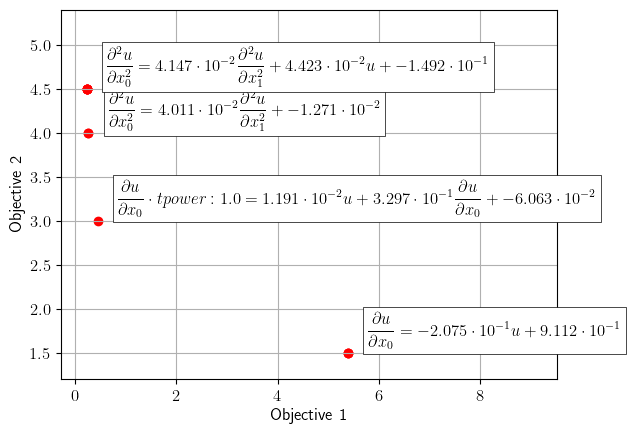

In [11]:
epde_search_obj.visualize_solutions()

In [12]:
systems = {'3' : epde_search_obj.get_equations_by_complexity(3)[0],
           '4' : epde_search_obj.get_equations_by_complexity(4)[0]}

In [14]:
t, x = np.unique(grids[0]), np.unique(grids[1])
print(t, x)

[0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125  0.1375 0.15   0.1625 0.175  0.1875 0.2    0.2125 0.225  0.2375
 0.25   0.2625 0.275  0.2875 0.3    0.3125 0.325  0.3375 0.35   0.3625
 0.375  0.3875 0.4    0.4125 0.425  0.4375 0.45   0.4625 0.475  0.4875
 0.5    0.5125 0.525  0.5375 0.55   0.5625 0.575  0.5875 0.6    0.6125
 0.625  0.6375 0.65   0.6625 0.675  0.6875 0.7    0.7125 0.725  0.7375
 0.75   0.7625 0.775  0.7875 0.8    0.8125 0.825  0.8375 0.85   0.8625
 0.875  0.8875 0.9    0.9125 0.925  0.9375 0.95   0.9625 0.975  0.9875
 1.    ] [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125  0.1375 0.15   0.1625 0.175  0.1875 0.2    0.2125 0.225  0.2375
 0.25   0.2625 0.275  0.2875 0.3    0.3125 0.325  0.3375 0.35   0.3625
 0.375  0.3875 0.4    0.4125 0.425  0.4375 0.45   0.4625 0.475  0.4875
 0.5    0.5125 0.525  0.5375 0.55   0.5625 0.575  0.5875 0.6    0.6125
 0.625  0.6375 0.65   0.6625 0.675  0.6875 0.7    0.7125 0.725  0.73

In [15]:
from epde.interface.solver_integration import BoundaryConditions, BOPElement

bnd_t = torch.cartesian_prod(torch.from_numpy(np.array([t[train_max + 1]], dtype=np.float64)),
                             torch.from_numpy(x)).float()

bop_1 = BOPElement(axis = 0, key = 'u_t', term = [None], power = 1, var = 0)
bop_1.set_grid(bnd_t)
bop_1.values = torch.from_numpy(data_test[0, ...]).float()
print('bop 1:', bop_1.values.shape)

t_der = epde_search_obj.saved_derivaties['u'][..., 0].reshape(grids_training[0].shape)
bop_2 = BOPElement(axis = 0, key = 'dudt', term = [0], power = 1, var = 0)
bop_2.set_grid(bnd_t)
bop_2.values = torch.from_numpy(t_der[-1, ...]).float()
print('bop 2:', bop_2.values.shape)

bnd_x1 = torch.cartesian_prod(torch.from_numpy(t[train_max:]),
                              torch.from_numpy(np.array([x[0]], dtype=np.float64))).float()
bnd_x2 = torch.cartesian_prod(torch.from_numpy(t[train_max:]),
                              torch.from_numpy(np.array([x[-1]], dtype=np.float64))).float()            

bop_3 = BOPElement(axis = 1, key = 'u_x1', term = [None], power = 1, var = 0)
bop_3.set_grid(bnd_x1)
bop_3.values = torch.from_numpy(data_test[..., 0]).float()
print('bop 3:', bop_3.values.shape)

bop_4 = BOPElement(axis = 1, key = 'u_x2', term = [None], power = 1, var = 0)
bop_4.set_grid(bnd_x2)
bop_4.values = torch.from_numpy(data_test[..., -1]).float()
print('bop 4:', bop_4.values.shape)

bop 1: torch.Size([81])
bop 2: torch.Size([81])
bop 3: torch.Size([41])
bop 4: torch.Size([41])


In [14]:
systems['4'].text_form

"0.04010726427900155 * d^2u/dx1^2{power: 1.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * du/dx1{power: 1.0} * x{power: 1.0} + 0.0 * d^2u/dx0^2{power: 1.0} * cos{power: 1.0, freq: 3.820521463918478, dim: 1.0} + -0.012709299997449876 = d^2u/dx0^2{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.19603355901571345}}"

In [30]:
epde_search_obj.optimizer.pareto_levels.

In [29]:
pred_u_v_4 = epde_search_obj.predict(system=systems['4'], boundary_conditions=[bop_1(), bop_2(), bop_3(), bop_4()], 
                                     grid = grids_test, mode='mat')

Using explicitly sent system of equations.
dimensionality is 2
grid.shape is (41, 81)
Shape of the grid for solver torch.Size([2, 41, 81])
Grid is  <class 'torch.Tensor'> torch.Size([2, 41, 81])
torch.Size([41, 81])
before Model_prepare: torch.float64
after Model_prepare: torch.float64


RuntimeError: The size of tensor a (3321) must match the size of tensor b (41) at non-singleton dimension 1

In [16]:
pred_u_v_4 = epde_search_obj.predict(system=systems['4'], boundary_conditions=[bop_1(), bop_2(), bop_3(), bop_4()], 
                                     grid = grids_test, mode='autograd')

Using explicitly sent system of equations.
dimensionality is 2
grid.shape is (41, 81)
Shape of the grid for solver torch.Size([3321, 2])
Grid is  <class 'torch.Tensor'> torch.Size([3321, 2])
torch.Size([2])
before Model_prepare: torch.float32
after Model_prepare: torch.float32
[2023-12-21 18:50:05.986867] initial (min) loss is inf
[2023-12-21 18:50:06.301728] Print every 5000 step
Step = 0 loss = 649.773193 normalized loss line= nanx+nan. There was 1 stop dings already.
[2023-12-21 19:02:19.107154] Print every 5000 step
Step = 5000 loss = 0.002659 normalized loss line= -0.001073x+1.115325. There was 1 stop dings already.
[2023-12-21 19:13:15.412673] Print every 5000 step
Step = 10000 loss = 0.000852 normalized loss line= 0.000353x+1.068117. There was 1 stop dings already.
[2023-12-21 19:24:07.942322] Print every 5000 step
Step = 15000 loss = 0.000415 normalized loss line= -0.000186x+1.026193. There was 1 stop dings already.
[2023-12-21 19:35:02.936061] Print every 5000 step
Step = 2000

In [19]:
pred_u_v_4_sh = pred_u_v_4.reshape(grids_test[0].shape)

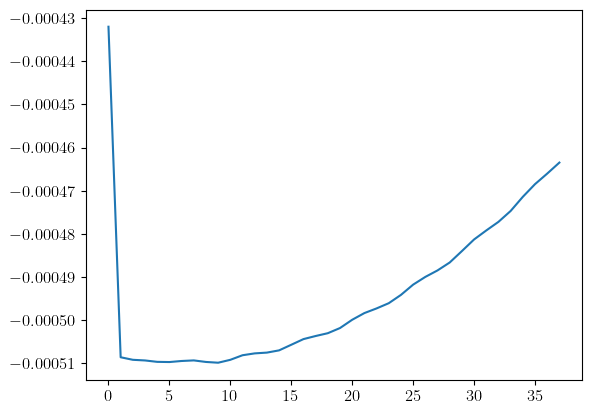

In [28]:
import matplotlib.pyplot as plt
plt.plot(data_training[:-2, 30] - 2*data_training[1:-1, 30] + data_training[2:, 30])
plt.show()

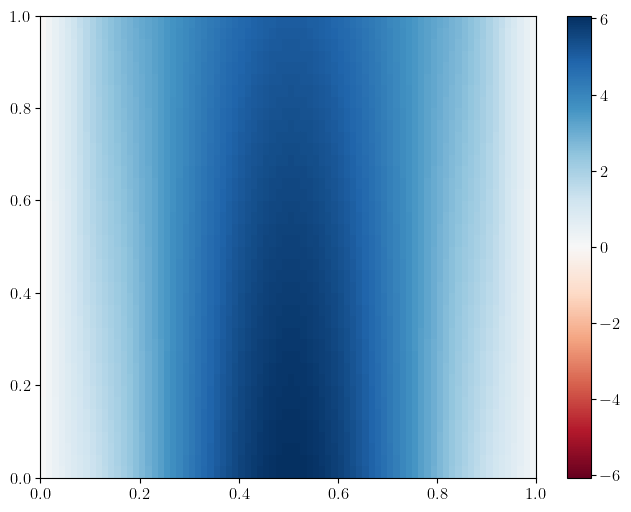

In [20]:
Heatmap(pred_u_v_4_sh)

In [24]:
grids[0]

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125],
       [0.025 , 0.025 , 0.025 , ..., 0.025 , 0.025 , 0.025 ],
       ...,
       [0.975 , 0.975 , 0.975 , ..., 0.975 , 0.975 , 0.975 ],
       [0.9875, 0.9875, 0.9875, ..., 0.9875, 0.9875, 0.9875],
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ]])

In [25]:
pred_u_v_4.reshape(grids[0].shape)

ValueError: cannot reshape array of size 3240 into shape (81,81)

In [ ]:
from epde.interface.solver_integration import BoundaryConditions, SolverAdapter, SystemSolverInterface

In [ ]:
adapter = SolverAdapter(var_number = len(systems['4'].vars_to_describe))

In [ ]:
ssi = SystemSolverInterface(systems['4'])

In [ ]:
ssi.form()

In [82]:
import epde.globals as global_var

In [84]:
global_var.grid_cache.get_all()[1]

[array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125],
        [0.025 , 0.025 , 0.025 , ..., 0.025 , 0.025 , 0.025 ],
        ...,
        [0.4625, 0.4625, 0.4625, ..., 0.4625, 0.4625, 0.4625],
        [0.475 , 0.475 , 0.475 , ..., 0.475 , 0.475 , 0.475 ],
        [0.4875, 0.4875, 0.4875, ..., 0.4875, 0.4875, 0.4875]]),
 array([[0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        ...,
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ]])]